# Jonathan Halverson
# Thursday, May 18, 2017
# Sentiment Analysis of Pride and Prejudice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

The text was taken from https://www.gutenberg.org/ebooks/1342

Load book and remove header:

In [2]:
with open('pride_and_prejudice_utf8_gutenberg.txt', 'r') as f:
     lines = f.readlines()
lines = lines[40:]

Decode utf-8 characters and clean:

In [3]:
lines = [line.decode('utf-8').replace('\r\n', '').encode('ascii', 'ignore') for line in lines]
lines[:10]

['It is a truth universally acknowledged, that a single man in possession',
 'of a good fortune, must be in want of a wife.',
 '',
 'However little known the feelings or views of such a man may be on his',
 'first entering a neighbourhood, this truth is so well fixed in the minds',
 'of the surrounding families, that he is considered the rightful property',
 'of some one or other of their daughters.',
 '',
 'My dear Mr. Bennet, said his lady to him one day, have you heard that',
 'Netherfield Park is let at last?']

Remove underscores and empty lines:

In [4]:
lines = [line.replace('_', '') for line in lines if line]
lines[:10]

['It is a truth universally acknowledged, that a single man in possession',
 'of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his',
 'first entering a neighbourhood, this truth is so well fixed in the minds',
 'of the surrounding families, that he is considered the rightful property',
 'of some one or other of their daughters.',
 'My dear Mr. Bennet, said his lady to him one day, have you heard that',
 'Netherfield Park is let at last?',
 'Mr. Bennet replied that he had not.',
 'But it is, returned she; for Mrs. Long has just been here, and she']

Use a regular expression to remove all non-alphabetical characters:

In [5]:
import re

lines = ' '.join(lines)
letters_only = re.sub('[^a-zA-Z]', ' ', lines)
words = letters_only.lower().split()
words[:10]

['it',
 'is',
 'a',
 'truth',
 'universally',
 'acknowledged',
 'that',
 'a',
 'single',
 'man']

In [6]:
len(words)

125119

Form blocks of text of a given number of consectutive words:

In [7]:
words_per_block = 100
num_blocks = len(words) / words_per_block
blocks = [words[s*words_per_block:(s+1)*words_per_block] for s in range(0, num_blocks)]

In [8]:
blocks[42]

['he',
 'was',
 'at',
 'the',
 'same',
 'time',
 'haughty',
 'reserved',
 'and',
 'fastidious',
 'and',
 'his',
 'manners',
 'though',
 'well',
 'bred',
 'were',
 'not',
 'inviting',
 'in',
 'that',
 'respect',
 'his',
 'friend',
 'had',
 'greatly',
 'the',
 'advantage',
 'bingley',
 'was',
 'sure',
 'of',
 'being',
 'liked',
 'wherever',
 'he',
 'appeared',
 'darcy',
 'was',
 'continually',
 'giving',
 'offense',
 'the',
 'manner',
 'in',
 'which',
 'they',
 'spoke',
 'of',
 'the',
 'meryton',
 'assembly',
 'was',
 'sufficiently',
 'characteristic',
 'bingley',
 'had',
 'never',
 'met',
 'with',
 'more',
 'pleasant',
 'people',
 'or',
 'prettier',
 'girls',
 'in',
 'his',
 'life',
 'everybody',
 'had',
 'been',
 'most',
 'kind',
 'and',
 'attentive',
 'to',
 'him',
 'there',
 'had',
 'been',
 'no',
 'formality',
 'no',
 'stiffness',
 'he',
 'had',
 'soon',
 'felt',
 'acquainted',
 'with',
 'all',
 'the',
 'room',
 'and',
 'as',
 'to',
 'miss',
 'bennet',
 'he']

Need the NRC Word-Emotion Association Lexicon to continue following the ODSC post:
https://opendatascience.com/blog/you-must-allow-me-to-tell-you-how-ardently-i-admire-and-love-natural-language-processing/

The following link was used to obtain the lexicon:

https://github.com/aneesha/cbd/blob/master/cronscripts/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt

In [9]:
from collections import defaultdict
import csv

wordList = defaultdict(list)
emotionList = defaultdict(list)
with open('NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt', 'r') as f:
     reader = csv.reader(f, delimiter='\t')
     # note that the end value was changed from 46 to 2
     headerRows = range(0, 2)
     for row in headerRows:
          next(reader)
     for word, emotion, present in reader:
          if int(present) == 1:
               wordList[word].append(emotion)
               emotionList[emotion].append(word)

In [10]:
def sentiment(block):
     s = 0
     for word in block:
          if (word in emotionList['positive']): s += 1
          if (word in emotionList['negative']): s -= 1
     return s

In [11]:
sentiments = [sentiment(block) for block in blocks]

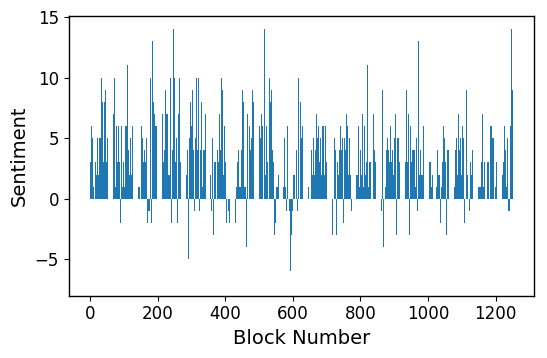

In [12]:
plt.bar(range(len(sentiments)), sentiments)
plt.xlabel('Block Number')
plt.ylabel('Sentiment')

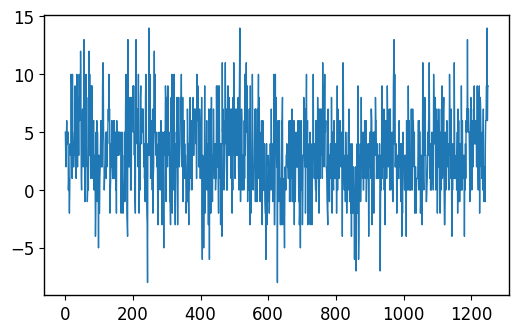

In [13]:
plt.plot(sentiments)

In [14]:
from scipy import fft, ifft

spec = fft(sentiments)

In [15]:
def low_pass(spec_, icut=10):
     fac = np.append(np.ones(icut), np.zeros(spec_.size - icut))
     assert fac.size == spec_.size, 'Big trouble'
     return ifft(fac * spec_).real

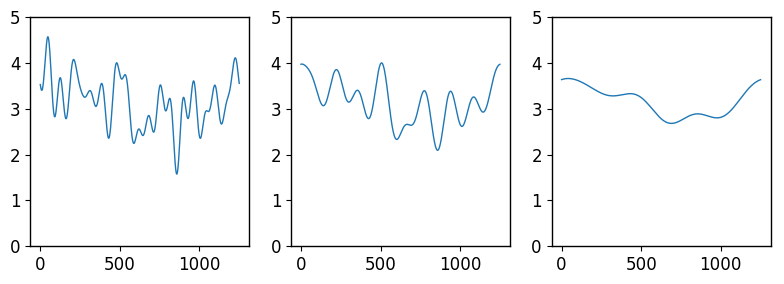

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
ax1.plot(low_pass(spec, icut=20))
ax2.plot(low_pass(spec, icut=10))
ax3.plot(low_pass(spec, icut=5))
ax1.set_ylim(0, 5)
ax2.set_ylim(0, 5)
ax3.set_ylim(0, 5)
plt.tight_layout()

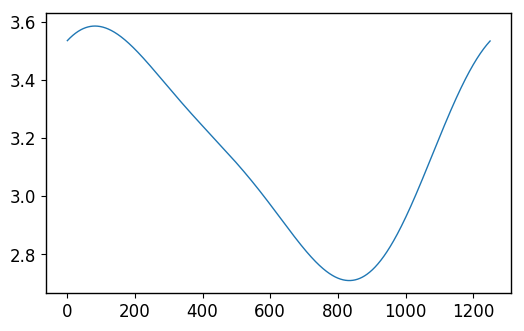

In [17]:
plt.plot(low_pass(spec, 3))

This corresponds very closely to the blog post. The differences are probably explained by the difference in blocks sizes.

In [18]:
iofile = 'NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt'
df = pd.read_csv(iofile, sep='\t', header=0, names=['word', 'emotion', 'value'])
df.head()

,word,emotion,value
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [19]:
len(sentiments)

1251

Let's drop the last block so that we have 2N blocks:

In [20]:
sentiments = sentiments[:-1]
len(sentiments)

1250

In [21]:
N = len(sentiments) / 2
N

625

Time then varies from 0 to 1249 so T=1249:

In [22]:
T = len(sentiments) - 1
T

1249

Create a dataframe:

In [23]:
df = pd.DataFrame({'t':range(len(sentiments)), 'f(t)':sentiments})
df.head()

,f(t),t
0,5,0
1,3,1
2,2,2
3,4,3
4,6,4


In [24]:
df['w'] = 2.0 * np.pi * df.t / T
df

,f(t),t,w
0,5,0,0.000000
1,3,1,0.005031
2,2,2,0.010061
3,4,3,0.015092
4,6,4,0.020122
5,4,5,0.025153
6,4,6,0.030183
7,5,7,0.035214
8,5,8,0.040245
9,0,9,0.045275
